In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

### We check whether we train with GPU

In [41]:
print(torch.cuda.is_available())

True


### Defining transformations
These transformations are identical to the ones performed on the resnet50 and vgg

In [42]:
# Define transforms for the data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

### Defining constansts for the training model
These constast are identical to the ones in resnet50 and vgg models that are in comparison.

In [43]:
EPOCH_COUNT = 20
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3
PATIENCE = 7

CHECKPOINT_FILENAME = "checkpoint.tar"

In [44]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Preparing dataset:
I am using the datasets.ImageFolder method provided by torchvision to create a dataset. It creates a dataset from a folder structure where each class has its own directory containing the images belonging to the class

In [45]:
# Define the data directory
data_dir = 'Larger'  # Update this path as needed

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=None)
CLASS_LIST = full_dataset.classes

# Split the dataset into train and test sets (80% train, 20% test)
train_idx, test_idx = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, stratify=full_dataset.targets)

# Create subsets for each set
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply appropriate transforms to each subset
train_dataset.dataset.transform = data_transforms['train']
test_dataset.dataset.transform = data_transforms['test']

# Create dataloaders for each set
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

### Printing meta information about the dataset

In [46]:
# Define the method to print dataset information
def print_dataset_info(full_dataset, train_dataset, test_dataset):
    num_classes = len(full_dataset.classes)
    print(f"Total number of samples in the full dataset: {len(full_dataset)}")
    print(f"Number of samples in the training set: {len(train_dataset)}")
    print(f"Number of samples in the test set: {len(test_dataset)}")
    print(f"Total number of classes: {num_classes}")

# Print dataset information
print_dataset_info(full_dataset, train_dataset, test_dataset)

Total number of samples in the full dataset: 6812
Number of samples in the training set: 5449
Number of samples in the test set: 1363
Total number of classes: 4


In [47]:
# Get class names
class_names = full_dataset.classes
print(class_names)

['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']


### Defining an early stopping method:

In [48]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

## Showcasing an array of images and their labels

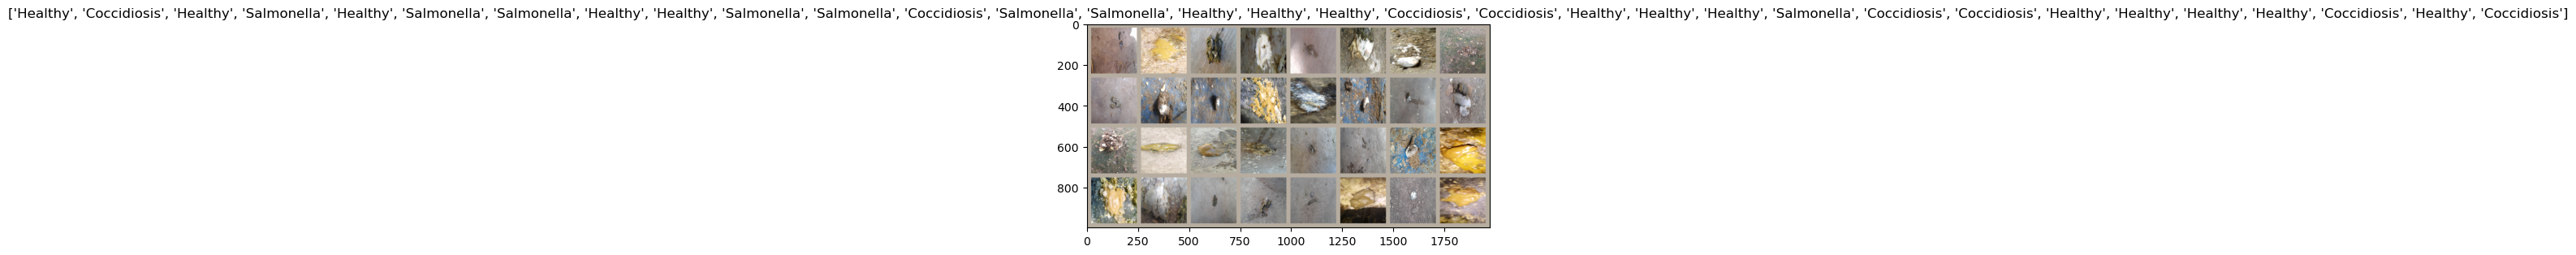

In [49]:
# Define a function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch with larger padding and bigger images
out = torchvision.utils.make_grid(inputs, padding=20, pad_value=1, scale_each=True)

# Display batch with labels
imshow(out, title=[class_names[x] for x in classes])
plt.show()


### Defining the training epoch function:

In [50]:
from tqdm import tqdm

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    # Wrap the train_loader with tqdm
    train_loader = tqdm(train_loader, desc="Training Batches")
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis=1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy


### Calculation of metrics for all the predictions

In [51]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

### Calculation of metrics for each of the class with selected treshold

In [52]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    if len(all_true_labels.shape) == 1:
        all_true_labels = all_true_labels[:, None]

    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)
        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

In [53]:
def evaluate_epoch(model, test_loader, criterion):
    model.eval()
    running_val_loss = np.array([], dtype=np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            confidences = torch.sigmoid(outputs)
            val_loss = criterion(outputs, labels)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis=1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)
    
    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats


In [54]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

### Loading and finetuning model

In [55]:
# Load a pretrained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
from datetime import datetime

LOAD_CHECKPOINT = False

def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam([
        {'params': model_ft.features.parameters(), 'lr': lr * 0.1},
        {'params': model_ft.classifier.parameters(), 'lr': lr}
    ])
    early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, verbose=True)

    training_history = None

    if LOAD_CHECKPOINT:
        training_history = load_checkpoint(filename, model, optimizer)
        start_epoch = training_history['epoch'] + 1
        train_loss_history = training_history['train_loss_history']
        accuracy_history = training_history['accuracy_history']
        train_accuracy_history = training_history['train_accuracy_history']
        val_loss_history = training_history['val_loss_history']
        precision_history = training_history['precision_history']
        recall_history = training_history['recall_history']
        f1_score_history = training_history['f1_score_history']
        stats_history = training_history['stats_history']
        conf_matrix = training_history['conf_matrix']
    else:
        start_epoch = 0
        train_loss_history = []
        val_loss_history = []
        accuracy_history = []
        train_accuracy_history = []
        precision_history = []
        recall_history = []
        f1_score_history = []
        stats_history = []
        conf_matrix = []

    for epoch in range(start_epoch, epoch_count):
        print('Starting training epoch... ', epoch)
        start_time = datetime.now()

        train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

        current_time = datetime.now()
        elapsed = seconds_to_time((current_time - start_time).total_seconds())
        print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

        print('Starting evaluation... ', start_time)
        start_time = datetime.now()

        avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, dataloaders["test"], loss_func)

        accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

        current_time = datetime.now()
        per_image = (current_time - start_time).total_seconds() / total_predictions
        print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
        print(f'Confusion matrix: {conf_matrix}')

        accuracy_history.append(accuracy)
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(train_loss)
        val_loss_history.append(avg_val_loss)
        precision_history.append(precision)
        recall_history.append(recall)
        f1_score_history.append(f1)
        stats_history.append(stats)

        print("Saving checkpoint...")
        checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "train_loss_history": train_loss_history,
            "accuracy_history": accuracy_history,
            "train_accuracy_history": train_accuracy_history,
            "val_loss_history": val_loss_history,
            "precision_history": precision_history,
            "recall_history": recall_history,
            "f1_score_history": f1_score_history,
            "stats_history": stats_history,
            "conf_matrix": conf_matrix
        }
        torch.save(checkpoint, filename)

        scheduler.step(avg_val_loss)

        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered. Reducing learning rate and resetting early stopping.")
            early_stopping.counter = 0

    return training_history

### Teaching of the model

In [57]:
print(f'Parameter count: {sum(p.numel() for p in model_ft.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model_ft, dataloaders["train"], dataloaders["test"], CHECKPOINT_FILENAME, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)

c:\Users\Lukas\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Parameter count: 2,228,996
Starting training epoch...  0


Training Batches: 100%|██████████| 171/171 [01:24<00:00,  2.01it/s]


Epoch: 0, Time: 1m24s, Loss: 0.18129712343215942
Starting evaluation...  2024-05-17 20:15:20.686968
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1327
Time: 20.88253778429934ms, Epoch 0, Train Loss: 0.1813, Val Loss: 0.0723, Accuracy: 0.9736, Precision: 0.9742, Recall: 0.9736, F1 score: 0.9737
Confusion matrix: [[420   0   1   0]
 [  0 389   7  16]
 [  1   1  70   3]
 [  1   4   2 448]]
Saving checkpoint...
Starting training epoch...  1


Training Batches: 100%|██████████| 171/171 [01:21<00:00,  2.09it/s]


Epoch: 1, Time: 1m21s, Loss: 0.04935060441493988
Starting evaluation...  2024-05-17 20:17:14.238256
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1334
Time: 19.999879677182687ms, Epoch 1, Train Loss: 0.0494, Val Loss: 0.0526, Accuracy: 0.9787, Precision: 0.9790, Recall: 0.9787, F1 score: 0.9788
Confusion matrix: [[419   0   2   0]
 [  0 400   6   6]
 [  0   4  70   1]
 [  0   9   1 445]]
Saving checkpoint...
Starting training epoch...  2


Training Batches: 100%|██████████| 171/171 [01:21<00:00,  2.10it/s]


Epoch: 2, Time: 1m21s, Loss: 0.02657821774482727
Starting evaluation...  2024-05-17 20:19:03.442868
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1347
Time: 20.308626559060894ms, Epoch 2, Train Loss: 0.0266, Val Loss: 0.0312, Accuracy: 0.9883, Precision: 0.9883, Recall: 0.9883, F1 score: 0.9882
Confusion matrix: [[420   0   1   0]
 [  0 409   1   2]
 [  0   3  70   2]
 [  0   7   0 448]]
Saving checkpoint...
Starting training epoch...  3


Training Batches: 100%|██████████| 171/171 [01:26<00:00,  1.99it/s]


Epoch: 3, Time: 1m26s, Loss: 0.02497013472020626
Starting evaluation...  2024-05-17 20:20:52.820961
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 19.94058620689655ms, Epoch 3, Train Loss: 0.0250, Val Loss: 0.0415, Accuracy: 0.9861, Precision: 0.9865, Recall: 0.9861, F1 score: 0.9860
Confusion matrix: [[421   0   0   0]
 [  0 412   0   0]
 [  0   6  68   1]
 [  1  11   0 443]]
Saving checkpoint...
Starting training epoch...  4


Training Batches: 100%|██████████| 171/171 [01:24<00:00,  2.02it/s]


Epoch: 4, Time: 1m24s, Loss: 0.0357082225382328
Starting evaluation...  2024-05-17 20:22:46.336482
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1345
Time: 21.799140132061627ms, Epoch 4, Train Loss: 0.0357, Val Loss: 0.0309, Accuracy: 0.9868, Precision: 0.9870, Recall: 0.9868, F1 score: 0.9867
Confusion matrix: [[420   0   0   1]
 [  0 403   0   9]
 [  1   2  68   4]
 [  0   1   0 454]]
Saving checkpoint...
Starting training epoch...  5


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.12it/s]


Epoch: 5, Time: 1m20s, Loss: 0.009594328701496124
Starting evaluation...  2024-05-17 20:24:41.012106
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1339
Time: 19.874746148202494ms, Epoch 5, Train Loss: 0.0096, Val Loss: 0.0511, Accuracy: 0.9824, Precision: 0.9823, Recall: 0.9824, F1 score: 0.9823
Confusion matrix: [[420   0   0   1]
 [  0 406   3   3]
 [  2   1  68   4]
 [  1   9   0 445]]
Saving checkpoint...
Starting training epoch...  6


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.12it/s]


Epoch: 6, Time: 1m20s, Loss: 0.013301445171236992
Starting evaluation...  2024-05-17 20:26:29.072554
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1345
Time: 19.872560528246517ms, Epoch 6, Train Loss: 0.0133, Val Loss: 0.0399, Accuracy: 0.9868, Precision: 0.9869, Recall: 0.9868, F1 score: 0.9868
Confusion matrix: [[421   0   0   0]
 [  0 408   1   3]
 [  0   4  71   0]
 [  2   7   1 445]]
Saving checkpoint...
Starting training epoch...  7


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.12it/s]


Epoch: 7, Time: 1m20s, Loss: 0.008331120945513248
Starting evaluation...  2024-05-17 20:28:16.990079
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1340
Time: 19.910597212032282ms, Epoch 7, Train Loss: 0.0083, Val Loss: 0.0550, Accuracy: 0.9831, Precision: 0.9835, Recall: 0.9831, F1 score: 0.9832
Confusion matrix: [[420   0   0   1]
 [  0 406   4   2]
 [  0   1  74   0]
 [  2  10   3 440]]
Saving checkpoint...
Starting training epoch...  8


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]


Epoch: 8, Time: 1m20s, Loss: 0.029993796721100807
Starting evaluation...  2024-05-17 20:30:04.929657
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1343
Time: 19.94395964783566ms, Epoch 8, Train Loss: 0.0300, Val Loss: 0.0451, Accuracy: 0.9853, Precision: 0.9856, Recall: 0.9853, F1 score: 0.9853
Confusion matrix: [[420   0   0   1]
 [  0 408   3   1]
 [  0   0  75   0]
 [  2  12   1 440]]
Saving checkpoint...
Starting training epoch...  9


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.12it/s]


Epoch: 9, Time: 1m20s, Loss: 0.02860761620104313
Starting evaluation...  2024-05-17 20:31:52.516249
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1347
Time: 19.88243873807777ms, Epoch 9, Train Loss: 0.0286, Val Loss: 0.0304, Accuracy: 0.9883, Precision: 0.9884, Recall: 0.9883, F1 score: 0.9883
Confusion matrix: [[420   1   0   0]
 [  0 410   1   1]
 [  0   2  73   0]
 [  1   8   2 444]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  10


Training Batches: 100%|██████████| 171/171 [01:22<00:00,  2.08it/s]


Epoch: 10, Time: 1m22s, Loss: 0.014697073958814144
Starting evaluation...  2024-05-17 20:33:40.410290
Class 0:
 Accuracy: 0.007202881152460984
 Precision: 0.011764705882352941
 Recall: 0.012135922330097087
 F1 Score: 0.01194743130227001
Total predictions:  1363
Correct predictions:  1346
Time: 19.757528980190756ms, Epoch 10, Train Loss: 0.0147, Val Loss: 0.0332, Accuracy: 0.9875, Precision: 0.9880, Recall: 0.9875, F1 score: 0.9876
Confusion matrix: [[420   0   1   0]
 [  0 406   3   3]
 [  0   1  74   0]
 [  1   4   4 446]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  11


Training Batches: 100%|██████████| 171/171 [01:21<00:00,  2.11it/s]


Epoch: 11, Time: 1m21s, Loss: 0.03510379418730736
Starting evaluation...  2024-05-17 20:35:29.601037
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1337
Time: 19.846564930300808ms, Epoch 11, Train Loss: 0.0351, Val Loss: 0.0682, Accuracy: 0.9809, Precision: 0.9813, Recall: 0.9809, F1 score: 0.9810
Confusion matrix: [[419   2   0   0]
 [  0 409   0   3]
 [  0   4  71   0]
 [  1  11   5 438]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  12


Training Batches: 100%|██████████| 171/171 [01:21<00:00,  2.10it/s]


Epoch: 12, Time: 1m21s, Loss: 0.010554395616054535
Starting evaluation...  2024-05-17 20:37:18.026387
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1346
Time: 19.830603081438003ms, Epoch 12, Train Loss: 0.0106, Val Loss: 0.0573, Accuracy: 0.9875, Precision: 0.9876, Recall: 0.9875, F1 score: 0.9875
Confusion matrix: [[421   0   0   0]
 [  0 407   1   4]
 [  0   2  73   0]
 [  2   6   2 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  13


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.14it/s]


Epoch: 13, Time: 1m20s, Loss: 0.0028319740667939186
Starting evaluation...  2024-05-17 20:39:06.595136
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1341
Time: 19.775551724137934ms, Epoch 13, Train Loss: 0.0028, Val Loss: 0.0546, Accuracy: 0.9839, Precision: 0.9839, Recall: 0.9839, F1 score: 0.9838
Confusion matrix: [[421   0   0   0]
 [  0 401   2   9]
 [  0   2  73   0]
 [  2   6   1 446]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  14


Training Batches: 100%|██████████| 171/171 [01:21<00:00,  2.11it/s]


Epoch: 14, Time: 1m21s, Loss: 0.0031605910044163465
Starting evaluation...  2024-05-17 20:40:53.768027
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 19.865545854732208ms, Epoch 14, Train Loss: 0.0032, Val Loss: 0.0512, Accuracy: 0.9861, Precision: 0.9862, Recall: 0.9861, F1 score: 0.9861
Confusion matrix: [[420   0   0   1]
 [  0 406   2   4]
 [  0   2  73   0]
 [  1   6   3 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  15


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.14it/s]


Epoch: 15, Time: 1m20s, Loss: 0.005185243207961321
Starting evaluation...  2024-05-17 20:42:42.192136
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 20.007814380044024ms, Epoch 15, Train Loss: 0.0052, Val Loss: 0.0527, Accuracy: 0.9861, Precision: 0.9864, Recall: 0.9861, F1 score: 0.9861
Confusion matrix: [[420   0   0   1]
 [  0 405   4   3]
 [  0   1  74   0]
 [  1   6   3 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  16


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]


Epoch: 16, Time: 1m20s, Loss: 0.013677481561899185
Starting evaluation...  2024-05-17 20:44:29.710044
Class 0:
 Accuracy: 0.003601440576230492
 Precision: 0.002380952380952381
 Recall: 0.0024271844660194173
 F1 Score: 0.002403846153846154
Total predictions:  1363
Correct predictions:  1341
Time: 19.580795304475423ms, Epoch 16, Train Loss: 0.0137, Val Loss: 0.0654, Accuracy: 0.9839, Precision: 0.9839, Recall: 0.9839, F1 score: 0.9839
Confusion matrix: [[420   1   0   0]
 [  1 405   2   4]
 [  0   3  71   1]
 [  1   6   3 445]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  17


Training Batches: 100%|██████████| 171/171 [01:20<00:00,  2.13it/s]


Epoch: 17, Time: 1m20s, Loss: 0.023069018498063087
Starting evaluation...  2024-05-17 20:46:16.896798
Class 0:
 Accuracy: 0.0024009603841536613
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 19.73114453411592ms, Epoch 17, Train Loss: 0.0231, Val Loss: 0.0531, Accuracy: 0.9861, Precision: 0.9866, Recall: 0.9861, F1 score: 0.9862
Confusion matrix: [[420   1   0   0]
 [  0 409   2   1]
 [  0   2  73   0]
 [  1   6   6 442]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  18


Training Batches: 100%|██████████| 171/171 [01:19<00:00,  2.14it/s]


Epoch: 18, Time: 1m19s, Loss: 0.006103767082095146
Starting evaluation...  2024-05-17 20:48:04.224590
Class 0:
 Accuracy: 0.0012004801920768306
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1344
Time: 19.736841526045488ms, Epoch 18, Train Loss: 0.0061, Val Loss: 0.0509, Accuracy: 0.9861, Precision: 0.9865, Recall: 0.9861, F1 score: 0.9861
Confusion matrix: [[420   1   0   0]
 [  0 409   2   1]
 [  0   2  73   0]
 [  1   7   5 442]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.
Starting training epoch...  19


Training Batches: 100%|██████████| 171/171 [01:19<00:00,  2.15it/s]


Epoch: 19, Time: 1m19s, Loss: 0.016639523208141327
Starting evaluation...  2024-05-17 20:49:51.138762
Class 0:
 Accuracy: 0.0
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0
Total predictions:  1363
Correct predictions:  1351
Time: 19.709699192956712ms, Epoch 19, Train Loss: 0.0166, Val Loss: 0.0391, Accuracy: 0.9912, Precision: 0.9913, Recall: 0.9912, F1 score: 0.9912
Confusion matrix: [[421   0   0   0]
 [  0 409   2   1]
 [  0   2  73   0]
 [  2   4   1 448]]
Saving checkpoint...
Early stopping triggered. Reducing learning rate and resetting early stopping.


## Display of statistics

c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lukas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint...


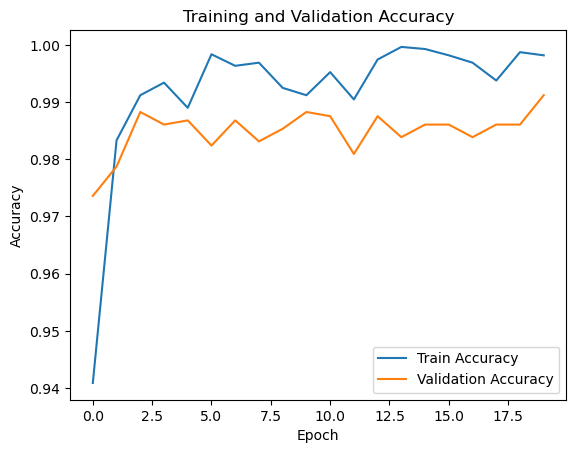

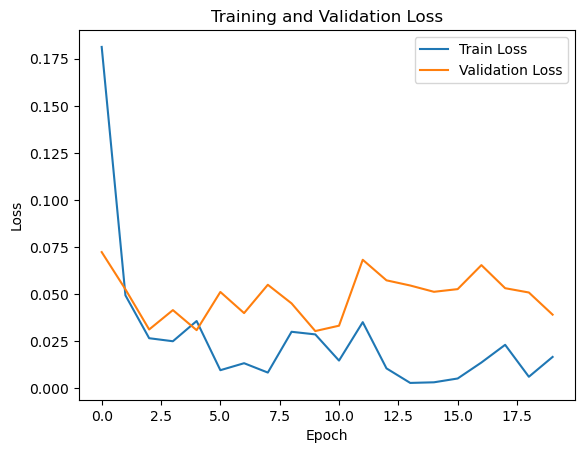

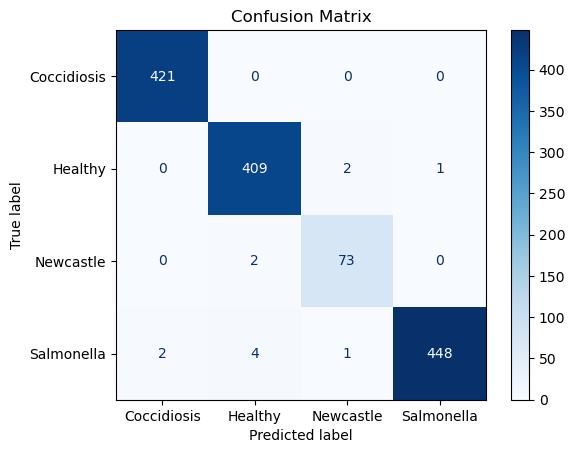

In [58]:
optimizer = optim.Adam([
        {'params': model_ft.features.parameters(), 'lr': LEARNING_RATE * 0.1},
        {'params': model_ft.classifier.parameters(), 'lr': LEARNING_RATE}
])

# Load a pretrained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

training_history = load_checkpoint(CHECKPOINT_FILENAME, model_ft, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()